This is an Example of Neural Network to predict 'Radical Prostatectomy Gleason Score for Prostate Cancer' using gene expression data.
-------

Reading the data:

In [1]:
import numpy as np
import pandas as pd

input = '/Users/ssaberi/Downloads/gdac.broadinstitute.org_PRAD.mRNAseq_Preprocess.Level_3.2016012800.0.0/PRAD.uncv2.mRNAseq_scaled_estimate.txt'
clinical = '/Users/ssaberi/Downloads/prad_tcga/prad_tcga_clinical_data.tsv'

data = pd.read_csv(input, delimiter= '\t' ,index_col = 0)   
clinical = pd.read_csv(clinical, delimiter= '\t' )  
clinical.set_index('Sample ID', inplace=True)


Choosing the 2000 genes with most variance, The idea is that these genes hold the most of signal for the subgroups present in the samples:

In [2]:
var = data.var(axis = 1)
item_2000 = sorted(var)[::-1][2000]
array = np.array(var > item_2000)  
data_filtered = data.loc[array] 
tmp = clinical.loc[:,['Radical Prostatectomy Gleason Score for Prostate Cancer']]

Creating labels and input data formats:
I find that log transforming the expression valueincreases the accuracy of the model.

In [28]:
all_data = pd.concat([data_filtered, pd.DataFrame.transpose(tmp)])

all_data = all_data.dropna(axis=1, how='any')

all_data = pd.DataFrame.as_matrix(all_data)

X = np.log(1+all_data[:2000,:])
Y = all_data[-1,:]
Y = Y - min(Y)
print(X.shape)


(2000, 496)


Importing keras Neural Network and other packages:

In [29]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
import matplotlib.pyplot as plt
from keras.regularizers import l2

Creating the NN model with Relu as the activation in the first layer and creating the last layer with softmax activation for categorical prediction of 
'Radical Prostatectomy Gleason Score for Prostate Cancer' and Choosing Adam for training and optimizing the NN model:

In [30]:
model = Sequential([
    Dense(2000, input_shape=(2000,) ),
    Activation('relu')
])
model.add(Dense(100))
model.add( Activation('sigmoid'))

model.add(Dense( len(np.unique(Y))))
model.add( Activation('softmax'))
optimizer = 'Adam' 
model.compile(optimizer = optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Spliting data to training and testing sets with 33% of the data chosen for the test:

In [31]:
from sklearn.model_selection import train_test_split, StratifiedKFold
seed = 2018
np.random.seed(seed)
X_train, X_test, Y_train, Y_test = train_test_split(np.transpose(X), Y, test_size=0.33, random_state=seed)



Preparing the predication format:

In [32]:
one_hot_labels_test = keras.utils.to_categorical(Y_test, num_classes = len(np.unique(Y)))
one_hot_labels_train = keras.utils.to_categorical(Y_train, num_classes = len(np.unique(Y)))


Training and validating the model:

In [40]:
history_Sigmoid = model.fit(X_train, one_hot_labels_train, validation_data = (X_test,one_hot_labels_test), epochs = 50, batch_size = 20)


Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 1s 3ms/step - loss: 0.0527 - acc: 0.9849 - val_loss: 2.5070 - val_acc: 0.5610
Epoch 2/50
332/332 [==============================] - 1s 3ms/step - loss: 0.0558 - acc: 0.9849 - val_loss: 2.6178 - val_acc: 0.5183
Epoch 3/50
332/332 [==============================] - 1s 3ms/step - loss: 0.0502 - acc: 0.9880 - val_loss: 2.6956 - val_acc: 0.4756
Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 0.1167 - acc: 0.9608 - val_loss: 2.6709 - val_acc: 0.5732
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 0.0934 - acc: 0.9789 - val_loss: 2.7275 - val_acc: 0.5061
Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 0.0484 - acc: 0.9880 - val_loss: 2.6804 - val_acc: 0.5122
Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 0.0438 - acc: 0.9910 - val_loss: 2.6031 - val_acc: 0.5244
Epoch 8/50
332/332 [==========

For simplicity we define a function for models with different emisions:

In [41]:
def NN(actived,  X_train, X_test, Y_train, Y_test, Neurons = 100 ):
    model = Sequential([
    Dense(2000, input_shape=(2000,) ),
    Activation('relu')
])
    model.add(Dense(Neurons))
    if actived == 'ELU':
        keras.layers.ELU(alpha=1.0)
        print('ELU acitvation')
    else:
        model.add( Activation (actived))


    model.add(Dense( len(np.unique(Y))))
    model.add( Activation('softmax'))
    optimizer = 'Adam' 
    model.compile(optimizer = optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    one_hot_labels_test = keras.utils.to_categorical(Y_test, num_classes = len(np.unique(Y_test)))
    one_hot_labels_train = keras.utils.to_categorical(Y_train, num_classes = len(np.unique(Y_train)))

    history = model.fit(X_train, one_hot_labels_train, validation_data = (X_test,one_hot_labels_test), 
                            epochs = 50, batch_size = 20)
    return history

I will redo this with another form of activation in the hidden layer (RELU): 

In [42]:
history_relu = NN( 'relu',  X_train, X_test, Y_train, Y_test, Neurons = 100 )


Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 1s 4ms/step - loss: 1.4690 - acc: 0.4337 - val_loss: 1.1878 - val_acc: 0.5488
Epoch 2/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2942 - acc: 0.4729 - val_loss: 1.1634 - val_acc: 0.5488
Epoch 3/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2628 - acc: 0.4729 - val_loss: 1.1524 - val_acc: 0.5488
Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2557 - acc: 0.4729 - val_loss: 1.1543 - val_acc: 0.5488
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2509 - acc: 0.4729 - val_loss: 1.1561 - val_acc: 0.5488
Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2474 - acc: 0.4729 - val_loss: 1.1424 - val_acc: 0.5488
Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2422 - acc: 0.4729 - val_loss: 1.1557 - val_acc: 0.5488
Epoch 8/50
332/332 [==========

In [43]:
history_ELU = NN( 'ELU',  X_train, X_test, Y_train, Y_test, Neurons = 100 )


ELU acitvation
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 1s 4ms/step - loss: 1.4142 - acc: 0.4608 - val_loss: 1.1558 - val_acc: 0.5488
Epoch 2/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2764 - acc: 0.4729 - val_loss: 1.1481 - val_acc: 0.5488
Epoch 3/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2522 - acc: 0.4729 - val_loss: 1.1610 - val_acc: 0.5488
Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2610 - acc: 0.4729 - val_loss: 1.1722 - val_acc: 0.5488
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2504 - acc: 0.4759 - val_loss: 1.1520 - val_acc: 0.5488
Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2353 - acc: 0.4729 - val_loss: 1.1310 - val_acc: 0.5488
Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2253 - acc: 0.4729 - val_loss: 1.1272 - val_acc: 0.5488
Epoch 8/50
332/

Plotting the results and the comparing them, It seems Sigmoid model works the best in terms of accurecy:

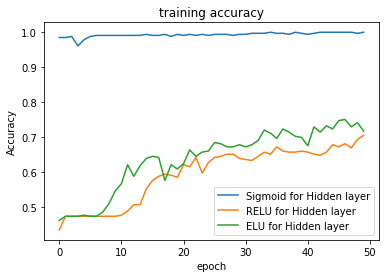

In [44]:
plt.plot(history_Sigmoid.history['acc'])
plt.plot(history_relu.history['acc'])
plt.plot(history_ELU.history['acc'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Sigmoid for Hidden layer','RELU for Hidden layer','ELU for Hidden layer'])
plt.title('training accuracy')
plt.show()

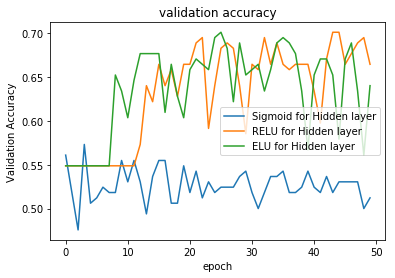

In [45]:
plt.plot(history_Sigmoid.history['val_acc'])
plt.plot(history_relu.history['val_acc'])
plt.plot(history_ELU.history['val_acc'])
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(['Sigmoid for Hidden layer','RELU for Hidden layer','ELU for Hidden layer'])
plt.title('validation accuracy')
plt.show()

To find out the best number of emission for the hidden layer, I iterate over 10 different random training/test sets:

In [46]:
seed = 2018
np.random.seed(seed)

validation_ELU     = []
accuracy_ELU      = []
validation_sigmoid = []
accuracy_sigmoid  = []
validation_relu    = []
accuracy_relu     = []
for i in range(10):
        ## ELU
        X_train, X_test, Y_train, Y_test = train_test_split(np.transpose(X), Y, test_size=0.33, random_state=seed)
        history_ELU = NN( 'ELU',  X_train, X_test, Y_train, Y_test, Neurons = 100 )
        validation_ELU.append(history_ELU.history['val_acc'] [-1] )
        accuracy_ELU.append(history_ELU.history['acc'] [-1])
        ## sigmoid
        history_sigmoid = NN( 'sigmoid',  X_train, X_test, Y_train, Y_test, Neurons = 100 )
        validation_sigmoid.append(history_sigmoid.history['val_acc'] [-1] )
        accuracy_sigmoid.append(history_sigmoid.history['acc'] [-1])
        ### relu
        history_relu = NN( 'relu',  X_train, X_test, Y_train, Y_test, Neurons = 100 )
        validation_relu.append(history_relu.history['val_acc'] [-1] )
        accuracy_relu.append(history_relu.history['acc'] [-1])        


ELU acitvation
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 1s 4ms/step - loss: 1.4346 - acc: 0.4488 - val_loss: 1.1671 - val_acc: 0.5488
Epoch 2/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2683 - acc: 0.4729 - val_loss: 1.1520 - val_acc: 0.5488
Epoch 3/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2776 - acc: 0.4729 - val_loss: 1.1417 - val_acc: 0.5488
Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2633 - acc: 0.4729 - val_loss: 1.1589 - val_acc: 0.5488
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2462 - acc: 0.4729 - val_loss: 1.1406 - val_acc: 0.5488
Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2379 - acc: 0.4729 - val_loss: 1.1648 - val_acc: 0.5488
Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2367 - acc: 0.4729 - val_loss: 1.1267 - val_acc: 0.5488
Epoch 8/50
332/

Epoch 12/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2307 - acc: 0.4759 - val_loss: 1.1148 - val_acc: 0.5488
Epoch 13/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2153 - acc: 0.4880 - val_loss: 1.1147 - val_acc: 0.5610
Epoch 14/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2003 - acc: 0.5361 - val_loss: 1.0923 - val_acc: 0.5488
Epoch 15/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2036 - acc: 0.5090 - val_loss: 1.0865 - val_acc: 0.6220
Epoch 16/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1793 - acc: 0.5181 - val_loss: 1.0723 - val_acc: 0.6098
Epoch 17/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1577 - acc: 0.5663 - val_loss: 1.0630 - val_acc: 0.6646
Epoch 18/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1442 - acc: 0.5964 - val_loss: 1.0484 - val_acc: 0.5732
Epoch 19/50
332/332 [==============================] - 1s 3ms/step - 

332/332 [==============================] - 1s 3ms/step - loss: 1.0850 - acc: 0.6175 - val_loss: 1.0203 - val_acc: 0.6707
Epoch 24/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0703 - acc: 0.6235 - val_loss: 1.0253 - val_acc: 0.5976
Epoch 25/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0915 - acc: 0.5753 - val_loss: 1.0235 - val_acc: 0.5976
Epoch 26/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0652 - acc: 0.6024 - val_loss: 0.9940 - val_acc: 0.6768
Epoch 27/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0440 - acc: 0.6054 - val_loss: 0.9839 - val_acc: 0.6829
Epoch 28/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0337 - acc: 0.6205 - val_loss: 0.9805 - val_acc: 0.6707
Epoch 29/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0126 - acc: 0.6295 - val_loss: 1.0219 - val_acc: 0.6402
Epoch 30/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9961

332/332 [==============================] - 1s 3ms/step - loss: 0.8286 - acc: 0.6777 - val_loss: 0.9354 - val_acc: 0.6890
Epoch 35/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8003 - acc: 0.7048 - val_loss: 0.9443 - val_acc: 0.6768
Epoch 36/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8205 - acc: 0.6837 - val_loss: 0.9881 - val_acc: 0.6463
Epoch 37/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8038 - acc: 0.7078 - val_loss: 0.9875 - val_acc: 0.6524
Epoch 38/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7989 - acc: 0.6867 - val_loss: 0.9848 - val_acc: 0.6646
Epoch 39/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7789 - acc: 0.7078 - val_loss: 0.9551 - val_acc: 0.6829
Epoch 40/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7808 - acc: 0.6988 - val_loss: 1.0154 - val_acc: 0.6220
Epoch 41/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7694

332/332 [==============================] - 1s 3ms/step - loss: 0.9241 - acc: 0.6657 - val_loss: 0.9131 - val_acc: 0.7073
Epoch 46/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9187 - acc: 0.6476 - val_loss: 0.9409 - val_acc: 0.6707
Epoch 47/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9129 - acc: 0.6536 - val_loss: 0.9140 - val_acc: 0.6890
Epoch 48/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9056 - acc: 0.6657 - val_loss: 0.9057 - val_acc: 0.7012
Epoch 49/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9166 - acc: 0.6596 - val_loss: 0.9333 - val_acc: 0.6707
Epoch 50/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8841 - acc: 0.6777 - val_loss: 0.9095 - val_acc: 0.7073
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 1s 4ms/step - loss: 1.4612 - acc: 0.4669 - val_loss: 1.1664 - val_acc: 0.5488
Epoch 2/50
332/332 [================

Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2593 - acc: 0.4669 - val_loss: 1.1310 - val_acc: 0.5488
Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2314 - acc: 0.4729 - val_loss: 1.1412 - val_acc: 0.5488
Epoch 8/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2224 - acc: 0.4729 - val_loss: 1.1172 - val_acc: 0.5488
Epoch 9/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2089 - acc: 0.4729 - val_loss: 1.1426 - val_acc: 0.6220
Epoch 10/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1964 - acc: 0.5241 - val_loss: 1.0979 - val_acc: 0.6220
Epoch 11/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1677 - acc: 0.5120 - val_loss: 1.0782 - val_acc: 0.5976
Epoch 12/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1695 - acc: 0.5572 - val_loss: 1.0622 - val_acc: 0.6341
Epoch 13/50
332/332 [==============================] - 1s 3ms/step - loss

332/332 [==============================] - 1s 3ms/step - loss: 1.2202 - acc: 0.4759 - val_loss: 1.1235 - val_acc: 0.5549
Epoch 18/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2150 - acc: 0.5000 - val_loss: 1.1209 - val_acc: 0.5549
Epoch 19/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2044 - acc: 0.5090 - val_loss: 1.1107 - val_acc: 0.5793
Epoch 20/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1913 - acc: 0.5090 - val_loss: 1.0933 - val_acc: 0.5610
Epoch 21/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1828 - acc: 0.5602 - val_loss: 1.0816 - val_acc: 0.5610
Epoch 22/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1758 - acc: 0.5331 - val_loss: 1.0946 - val_acc: 0.6524
Epoch 23/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1549 - acc: 0.5843 - val_loss: 1.0622 - val_acc: 0.5854
Epoch 24/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1431

332/332 [==============================] - 1s 3ms/step - loss: 1.0113 - acc: 0.6295 - val_loss: 0.9849 - val_acc: 0.6646
Epoch 29/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0018 - acc: 0.6205 - val_loss: 0.9579 - val_acc: 0.6768
Epoch 30/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0032 - acc: 0.6084 - val_loss: 0.9497 - val_acc: 0.6768
Epoch 31/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9736 - acc: 0.6506 - val_loss: 0.9668 - val_acc: 0.6768
Epoch 32/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9744 - acc: 0.6175 - val_loss: 0.9411 - val_acc: 0.6829
Epoch 33/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9495 - acc: 0.6325 - val_loss: 0.9503 - val_acc: 0.6890
Epoch 34/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9476 - acc: 0.6295 - val_loss: 0.9410 - val_acc: 0.6768
Epoch 35/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9488

332/332 [==============================] - 1s 3ms/step - loss: 0.7834 - acc: 0.6988 - val_loss: 0.9780 - val_acc: 0.6402
Epoch 40/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7816 - acc: 0.6988 - val_loss: 0.9748 - val_acc: 0.6341
Epoch 41/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7519 - acc: 0.7139 - val_loss: 0.9805 - val_acc: 0.6585
Epoch 42/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7367 - acc: 0.7139 - val_loss: 1.0238 - val_acc: 0.6220
Epoch 43/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7512 - acc: 0.6928 - val_loss: 1.0045 - val_acc: 0.6951
Epoch 44/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7386 - acc: 0.7139 - val_loss: 1.0592 - val_acc: 0.5732
Epoch 45/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7426 - acc: 0.7229 - val_loss: 1.0042 - val_acc: 0.6402
Epoch 46/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7025

332/332 [==============================] - 1s 3ms/step - loss: 0.8613 - acc: 0.6928 - val_loss: 1.0040 - val_acc: 0.6402
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 2s 5ms/step - loss: 1.4991 - acc: 0.4367 - val_loss: 1.2257 - val_acc: 0.5488
Epoch 2/50
332/332 [==============================] - 1s 3ms/step - loss: 1.3023 - acc: 0.4729 - val_loss: 1.1589 - val_acc: 0.5488
Epoch 3/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2759 - acc: 0.4729 - val_loss: 1.1611 - val_acc: 0.5488
Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2647 - acc: 0.4729 - val_loss: 1.1576 - val_acc: 0.5488
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2584 - acc: 0.4729 - val_loss: 1.1534 - val_acc: 0.5488
Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2547 - acc: 0.4729 - val_loss: 1.1564 - val_acc: 0.5488
Epoch 7/50
332/332 [=====================

332/332 [==============================] - 1s 3ms/step - loss: 1.1261 - acc: 0.5994 - val_loss: 1.0544 - val_acc: 0.5732
Epoch 12/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0986 - acc: 0.5934 - val_loss: 1.0222 - val_acc: 0.6707
Epoch 13/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0892 - acc: 0.5994 - val_loss: 0.9897 - val_acc: 0.6585
Epoch 14/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0590 - acc: 0.6205 - val_loss: 0.9771 - val_acc: 0.6768
Epoch 15/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0550 - acc: 0.6024 - val_loss: 1.0296 - val_acc: 0.6280
Epoch 16/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0249 - acc: 0.6175 - val_loss: 1.0467 - val_acc: 0.5915
Epoch 17/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0559 - acc: 0.5873 - val_loss: 1.0259 - val_acc: 0.5915
Epoch 18/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9989

332/332 [==============================] - 1s 3ms/step - loss: 1.0811 - acc: 0.5904 - val_loss: 1.0252 - val_acc: 0.6707
Epoch 23/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0726 - acc: 0.6205 - val_loss: 0.9863 - val_acc: 0.6829
Epoch 24/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0603 - acc: 0.6175 - val_loss: 0.9863 - val_acc: 0.6829
Epoch 25/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0477 - acc: 0.6295 - val_loss: 0.9739 - val_acc: 0.6768
Epoch 26/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0372 - acc: 0.6325 - val_loss: 0.9678 - val_acc: 0.6951
Epoch 27/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0324 - acc: 0.6446 - val_loss: 0.9584 - val_acc: 0.6890
Epoch 28/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0119 - acc: 0.6476 - val_loss: 0.9636 - val_acc: 0.6768
Epoch 29/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0027

332/332 [==============================] - 1s 3ms/step - loss: 0.9852 - acc: 0.6175 - val_loss: 0.9365 - val_acc: 0.6890
Epoch 34/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9321 - acc: 0.6386 - val_loss: 1.0027 - val_acc: 0.6463
Epoch 35/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9265 - acc: 0.6476 - val_loss: 0.9520 - val_acc: 0.6768
Epoch 36/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9166 - acc: 0.6446 - val_loss: 0.9400 - val_acc: 0.6768
Epoch 37/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8997 - acc: 0.6596 - val_loss: 0.9496 - val_acc: 0.6585
Epoch 38/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8909 - acc: 0.6657 - val_loss: 0.9356 - val_acc: 0.6890
Epoch 39/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9299 - acc: 0.6175 - val_loss: 0.9628 - val_acc: 0.6524
Epoch 40/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9063

332/332 [==============================] - 1s 3ms/step - loss: 0.7215 - acc: 0.7199 - val_loss: 0.9869 - val_acc: 0.6341
Epoch 45/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7468 - acc: 0.7048 - val_loss: 0.9938 - val_acc: 0.6585
Epoch 46/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7379 - acc: 0.6807 - val_loss: 1.0245 - val_acc: 0.6220
Epoch 47/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7019 - acc: 0.7229 - val_loss: 1.0011 - val_acc: 0.6646
Epoch 48/50
332/332 [==============================] - 1s 3ms/step - loss: 0.6838 - acc: 0.7259 - val_loss: 1.0503 - val_acc: 0.6341
Epoch 49/50
332/332 [==============================] - 1s 3ms/step - loss: 0.6773 - acc: 0.7590 - val_loss: 1.0028 - val_acc: 0.6707
Epoch 50/50
332/332 [==============================] - 1s 3ms/step - loss: 0.6901 - acc: 0.7018 - val_loss: 1.0242 - val_acc: 0.6585
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [===============

332/332 [==============================] - 1s 3ms/step - loss: 1.2522 - acc: 0.4729 - val_loss: 1.1546 - val_acc: 0.5488
Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2478 - acc: 0.4729 - val_loss: 1.1506 - val_acc: 0.5488
Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2474 - acc: 0.4729 - val_loss: 1.1521 - val_acc: 0.5488
Epoch 8/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2451 - acc: 0.4729 - val_loss: 1.1513 - val_acc: 0.5488
Epoch 9/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2435 - acc: 0.4729 - val_loss: 1.1408 - val_acc: 0.5488
Epoch 10/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2378 - acc: 0.4729 - val_loss: 1.1456 - val_acc: 0.5488
Epoch 11/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2311 - acc: 0.4729 - val_loss: 1.1383 - val_acc: 0.5488
Epoch 12/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2280 - a

332/332 [==============================] - 1s 3ms/step - loss: 1.0228 - acc: 0.6355 - val_loss: 0.9637 - val_acc: 0.6707
Epoch 17/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9980 - acc: 0.6446 - val_loss: 0.9640 - val_acc: 0.6890
Epoch 18/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9988 - acc: 0.6235 - val_loss: 0.9539 - val_acc: 0.6890
Epoch 19/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9728 - acc: 0.6446 - val_loss: 0.9574 - val_acc: 0.6890
Epoch 20/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9527 - acc: 0.6446 - val_loss: 0.9330 - val_acc: 0.6829
Epoch 21/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9465 - acc: 0.6205 - val_loss: 0.9558 - val_acc: 0.6585
Epoch 22/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9567 - acc: 0.6265 - val_loss: 0.9867 - val_acc: 0.6463
Epoch 23/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9128

332/332 [==============================] - 1s 3ms/step - loss: 1.0435 - acc: 0.6416 - val_loss: 0.9684 - val_acc: 0.6768
Epoch 28/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0358 - acc: 0.6416 - val_loss: 0.9613 - val_acc: 0.6707
Epoch 29/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0273 - acc: 0.6205 - val_loss: 0.9772 - val_acc: 0.6768
Epoch 30/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0334 - acc: 0.6235 - val_loss: 0.9686 - val_acc: 0.6890
Epoch 31/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0126 - acc: 0.6416 - val_loss: 0.9533 - val_acc: 0.6829
Epoch 32/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9929 - acc: 0.6506 - val_loss: 0.9525 - val_acc: 0.6768
Epoch 33/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9929 - acc: 0.6506 - val_loss: 0.9615 - val_acc: 0.6707
Epoch 34/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9765

332/332 [==============================] - 1s 3ms/step - loss: 0.9285 - acc: 0.6476 - val_loss: 0.9268 - val_acc: 0.6768
Epoch 39/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9229 - acc: 0.6566 - val_loss: 0.9448 - val_acc: 0.6707
Epoch 40/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9072 - acc: 0.6596 - val_loss: 0.9548 - val_acc: 0.6646
Epoch 41/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9058 - acc: 0.6476 - val_loss: 0.9191 - val_acc: 0.7012
Epoch 42/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9017 - acc: 0.6476 - val_loss: 0.9545 - val_acc: 0.6707
Epoch 43/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9039 - acc: 0.6536 - val_loss: 0.9314 - val_acc: 0.6585
Epoch 44/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8729 - acc: 0.6627 - val_loss: 0.9275 - val_acc: 0.7012
Epoch 45/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8675

332/332 [==============================] - 1s 3ms/step - loss: 0.6952 - acc: 0.7440 - val_loss: 0.9984 - val_acc: 0.6768
Epoch 50/50
332/332 [==============================] - 1s 3ms/step - loss: 0.6703 - acc: 0.7380 - val_loss: 1.0439 - val_acc: 0.6463
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 2s 6ms/step - loss: 1.4298 - acc: 0.3614 - val_loss: 1.1636 - val_acc: 0.5488
Epoch 2/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2731 - acc: 0.4729 - val_loss: 1.1626 - val_acc: 0.5488
Epoch 3/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2576 - acc: 0.4729 - val_loss: 1.1647 - val_acc: 0.5488
Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2610 - acc: 0.4729 - val_loss: 1.1603 - val_acc: 0.5488
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2573 - acc: 0.4729 - val_loss: 1.1531 - val_acc: 0.5488
Epoch 6/50
332/332 [====================

332/332 [==============================] - 1s 3ms/step - loss: 1.2419 - acc: 0.4729 - val_loss: 1.1382 - val_acc: 0.5488
Epoch 11/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2370 - acc: 0.4729 - val_loss: 1.1326 - val_acc: 0.5488
Epoch 12/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2279 - acc: 0.4729 - val_loss: 1.1322 - val_acc: 0.5488
Epoch 13/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2206 - acc: 0.4729 - val_loss: 1.1306 - val_acc: 0.5488
Epoch 14/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2169 - acc: 0.4759 - val_loss: 1.1132 - val_acc: 0.5488
Epoch 15/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2088 - acc: 0.4849 - val_loss: 1.1287 - val_acc: 0.5732
Epoch 16/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1980 - acc: 0.4819 - val_loss: 1.1115 - val_acc: 0.5732
Epoch 17/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1843

332/332 [==============================] - 1s 3ms/step - loss: 0.9439 - acc: 0.6536 - val_loss: 0.9703 - val_acc: 0.6646
Epoch 22/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9370 - acc: 0.6506 - val_loss: 0.9281 - val_acc: 0.6951
Epoch 23/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9344 - acc: 0.6506 - val_loss: 0.9744 - val_acc: 0.6524
Epoch 24/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9163 - acc: 0.6536 - val_loss: 0.9199 - val_acc: 0.6890
Epoch 25/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9024 - acc: 0.6566 - val_loss: 0.9198 - val_acc: 0.6951
Epoch 26/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8960 - acc: 0.6506 - val_loss: 0.9422 - val_acc: 0.6707
Epoch 27/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8771 - acc: 0.6687 - val_loss: 0.9337 - val_acc: 0.6890
Epoch 28/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8765

332/332 [==============================] - 1s 3ms/step - loss: 1.0166 - acc: 0.6386 - val_loss: 0.9636 - val_acc: 0.6829
Epoch 33/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0058 - acc: 0.6476 - val_loss: 0.9465 - val_acc: 0.6951
Epoch 34/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0071 - acc: 0.6295 - val_loss: 1.0211 - val_acc: 0.6220
Epoch 35/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9930 - acc: 0.6446 - val_loss: 1.0258 - val_acc: 0.6220
Epoch 36/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0148 - acc: 0.6265 - val_loss: 0.9587 - val_acc: 0.6524
Epoch 37/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9901 - acc: 0.6355 - val_loss: 0.9424 - val_acc: 0.6768
Epoch 38/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9791 - acc: 0.6596 - val_loss: 0.9344 - val_acc: 0.6951
Epoch 39/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9645

332/332 [==============================] - 1s 3ms/step - loss: 0.8956 - acc: 0.6627 - val_loss: 0.9284 - val_acc: 0.6768
Epoch 44/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8869 - acc: 0.6777 - val_loss: 0.9448 - val_acc: 0.6646
Epoch 45/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9026 - acc: 0.6416 - val_loss: 0.9360 - val_acc: 0.6829
Epoch 46/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9045 - acc: 0.6596 - val_loss: 0.9170 - val_acc: 0.6829
Epoch 47/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8801 - acc: 0.6687 - val_loss: 0.9121 - val_acc: 0.6890
Epoch 48/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8516 - acc: 0.6657 - val_loss: 1.0283 - val_acc: 0.6098
Epoch 49/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8748 - acc: 0.6657 - val_loss: 0.9256 - val_acc: 0.6890
Epoch 50/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8499

Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2565 - acc: 0.4729 - val_loss: 1.1550 - val_acc: 0.5488
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2517 - acc: 0.4729 - val_loss: 1.1482 - val_acc: 0.5488
Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2505 - acc: 0.4729 - val_loss: 1.1462 - val_acc: 0.5488
Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2464 - acc: 0.4729 - val_loss: 1.1359 - val_acc: 0.5488
Epoch 8/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2429 - acc: 0.4729 - val_loss: 1.1432 - val_acc: 0.5488
Epoch 9/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2383 - acc: 0.4729 - val_loss: 1.1295 - val_acc: 0.5488
Epoch 10/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2268 - acc: 0.4729 - val_loss: 1.1368 - val_acc: 0.5549
Epoch 11/50
332/332 [==============================] - 1s 3ms/step - loss: 

332/332 [==============================] - 1s 3ms/step - loss: 1.1961 - acc: 0.4970 - val_loss: 1.1089 - val_acc: 0.6037
Epoch 16/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1735 - acc: 0.5422 - val_loss: 1.0846 - val_acc: 0.5671
Epoch 17/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1667 - acc: 0.5452 - val_loss: 1.0728 - val_acc: 0.6159
Epoch 18/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1456 - acc: 0.5392 - val_loss: 1.1029 - val_acc: 0.6524
Epoch 19/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1443 - acc: 0.5813 - val_loss: 1.0485 - val_acc: 0.6280
Epoch 20/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1769 - acc: 0.5482 - val_loss: 1.0892 - val_acc: 0.5549
Epoch 21/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1226 - acc: 0.5753 - val_loss: 1.0281 - val_acc: 0.6463
Epoch 22/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0947

Ploting the accuracies and comparing it to the previouse model "Accuracy"

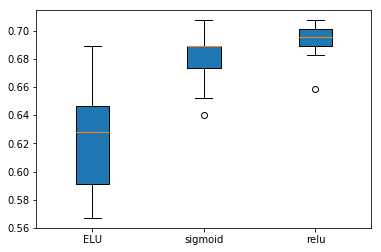

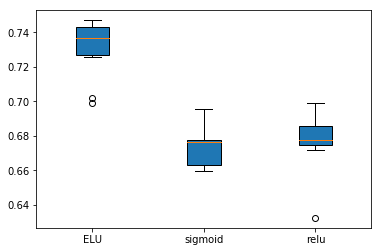

In [48]:
validation   = [ validation_ELU , validation_sigmoid , validation_relu   ]
accuracy     = [ accuracy_ELU  , accuracy_sigmoid  , accuracy_relu    ]
ticks = ['ELU', 'sigmoid', 'relu']
bx1 = plt.boxplot(validation, patch_artist=True)
plt.xticks(range(1, len(ticks) + 1 , 1), ticks)
plt.show()

bx2 = plt.boxplot(accuracy, patch_artist=True)
plt.xticks(range(1, len(ticks) + 1 , 1), ticks)
plt.show()


Therefore ELU works the best in our case, now testing for different number of neurons in the hidden layer:

In [50]:
validation_elu    = []
accuracy_elu      = []
for Neurons in range(1,7):
    validation_elu.append([])
    accuracy_elu.append([])
    for i in range(10):
        ### elu
        X_train, X_test, Y_train, Y_test = train_test_split(np.transpose(X), Y, test_size=0.33, random_state=seed)
        history_elu = NN( 'ELU',  X_train, X_test, Y_train, Y_test, Neurons = 4* (2**Neurons) )
        validation_elu[-1].append(history_elu.history['val_acc'] [-1] )
        accuracy_elu[-1].append(history_elu.history['acc'] [-1])



ELU acitvation
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 2s 7ms/step - loss: 1.4832 - acc: 0.4127 - val_loss: 1.2638 - val_acc: 0.5488
Epoch 2/50
332/332 [==============================] - 1s 3ms/step - loss: 1.3313 - acc: 0.4729 - val_loss: 1.2142 - val_acc: 0.5488
Epoch 3/50
332/332 [==============================] - 1s 3ms/step - loss: 1.3030 - acc: 0.4729 - val_loss: 1.2085 - val_acc: 0.5488
Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2904 - acc: 0.4729 - val_loss: 1.1837 - val_acc: 0.5488
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2799 - acc: 0.4729 - val_loss: 1.1818 - val_acc: 0.5488
Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2611 - acc: 0.4729 - val_loss: 1.1663 - val_acc: 0.5488
Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2574 - acc: 0.4729 - val_loss: 1.1552 - val_acc: 0.5488
Epoch 8/50
332/

Epoch 12/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2302 - acc: 0.4729 - val_loss: 1.1396 - val_acc: 0.5488
Epoch 13/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2251 - acc: 0.4729 - val_loss: 1.1303 - val_acc: 0.5488
Epoch 14/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2236 - acc: 0.4849 - val_loss: 1.1311 - val_acc: 0.5488
Epoch 15/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2172 - acc: 0.4729 - val_loss: 1.1235 - val_acc: 0.5488
Epoch 16/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2062 - acc: 0.4729 - val_loss: 1.1213 - val_acc: 0.5488
Epoch 17/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1981 - acc: 0.4849 - val_loss: 1.1247 - val_acc: 0.5732
Epoch 18/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1948 - acc: 0.5211 - val_loss: 1.1081 - val_acc: 0.5610
Epoch 19/50
332/332 [==============================] - 1s 3ms/step - 

332/332 [==============================] - 1s 3ms/step - loss: 1.0763 - acc: 0.6295 - val_loss: 1.0012 - val_acc: 0.6829
Epoch 24/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0611 - acc: 0.6325 - val_loss: 0.9903 - val_acc: 0.6707
Epoch 25/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0546 - acc: 0.6295 - val_loss: 0.9921 - val_acc: 0.6890
Epoch 26/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0447 - acc: 0.6416 - val_loss: 0.9959 - val_acc: 0.6890
Epoch 27/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0302 - acc: 0.6446 - val_loss: 0.9744 - val_acc: 0.6707
Epoch 28/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0345 - acc: 0.6476 - val_loss: 0.9715 - val_acc: 0.6707
Epoch 29/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0366 - acc: 0.6114 - val_loss: 1.0511 - val_acc: 0.6098
Epoch 30/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0154

332/332 [==============================] - 1s 3ms/step - loss: 1.0137 - acc: 0.6506 - val_loss: 1.0162 - val_acc: 0.6585
Epoch 35/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0131 - acc: 0.6386 - val_loss: 0.9945 - val_acc: 0.6585
Epoch 36/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9936 - acc: 0.6416 - val_loss: 0.9795 - val_acc: 0.6707
Epoch 37/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9789 - acc: 0.6506 - val_loss: 0.9650 - val_acc: 0.6707
Epoch 38/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9704 - acc: 0.6506 - val_loss: 0.9652 - val_acc: 0.6707
Epoch 39/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9973 - acc: 0.6325 - val_loss: 0.9695 - val_acc: 0.6707
Epoch 40/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9621 - acc: 0.6536 - val_loss: 0.9458 - val_acc: 0.6829
Epoch 41/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9521

332/332 [==============================] - 1s 3ms/step - loss: 0.8769 - acc: 0.6687 - val_loss: 0.9560 - val_acc: 0.6707
Epoch 46/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8801 - acc: 0.6566 - val_loss: 0.9794 - val_acc: 0.6707
Epoch 47/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8602 - acc: 0.6777 - val_loss: 0.9555 - val_acc: 0.6768
Epoch 48/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8490 - acc: 0.6837 - val_loss: 0.9833 - val_acc: 0.6585
Epoch 49/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8532 - acc: 0.6867 - val_loss: 0.9574 - val_acc: 0.6768
Epoch 50/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8533 - acc: 0.6777 - val_loss: 0.9879 - val_acc: 0.6524
ELU acitvation
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 2s 7ms/step - loss: 1.4793 - acc: 0.4307 - val_loss: 1.2541 - val_acc: 0.5488
Epoch 2/50
332/332 [=

Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2509 - acc: 0.4729 - val_loss: 1.1496 - val_acc: 0.5488
Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2488 - acc: 0.4729 - val_loss: 1.1509 - val_acc: 0.5488
Epoch 8/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2469 - acc: 0.4729 - val_loss: 1.1479 - val_acc: 0.5488
Epoch 9/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2428 - acc: 0.4729 - val_loss: 1.1449 - val_acc: 0.5488
Epoch 10/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2438 - acc: 0.4729 - val_loss: 1.1418 - val_acc: 0.5488
Epoch 11/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2471 - acc: 0.4729 - val_loss: 1.1437 - val_acc: 0.5488
Epoch 12/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2300 - acc: 0.4729 - val_loss: 1.1371 - val_acc: 0.5488
Epoch 13/50
332/332 [==============================] - 1s 3ms/step - loss

332/332 [==============================] - 1s 3ms/step - loss: 1.1731 - acc: 0.5211 - val_loss: 1.1268 - val_acc: 0.6098
Epoch 18/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1833 - acc: 0.5211 - val_loss: 1.0766 - val_acc: 0.5732
Epoch 19/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1477 - acc: 0.5964 - val_loss: 1.0660 - val_acc: 0.5915
Epoch 20/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1338 - acc: 0.5994 - val_loss: 1.0508 - val_acc: 0.6341
Epoch 21/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1169 - acc: 0.5783 - val_loss: 1.0474 - val_acc: 0.6341
Epoch 22/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1021 - acc: 0.6145 - val_loss: 1.0312 - val_acc: 0.5976
Epoch 23/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1015 - acc: 0.5693 - val_loss: 1.0489 - val_acc: 0.6646
Epoch 24/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0910

332/332 [==============================] - 1s 3ms/step - loss: 1.0201 - acc: 0.6235 - val_loss: 0.9872 - val_acc: 0.6524
Epoch 29/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0084 - acc: 0.6476 - val_loss: 0.9541 - val_acc: 0.6951
Epoch 30/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9938 - acc: 0.6566 - val_loss: 0.9438 - val_acc: 0.6890
Epoch 31/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9813 - acc: 0.6386 - val_loss: 0.9927 - val_acc: 0.6585
Epoch 32/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9833 - acc: 0.6355 - val_loss: 0.9486 - val_acc: 0.6890
Epoch 33/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9704 - acc: 0.6596 - val_loss: 0.9273 - val_acc: 0.6829
Epoch 34/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9616 - acc: 0.6325 - val_loss: 0.9339 - val_acc: 0.6768
Epoch 35/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9630

332/332 [==============================] - 1s 3ms/step - loss: 0.9617 - acc: 0.6627 - val_loss: 0.9904 - val_acc: 0.6463
Epoch 40/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9596 - acc: 0.6355 - val_loss: 0.9682 - val_acc: 0.6707
Epoch 41/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9582 - acc: 0.6476 - val_loss: 0.9601 - val_acc: 0.6829
Epoch 42/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9367 - acc: 0.6627 - val_loss: 0.9885 - val_acc: 0.6402
Epoch 43/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9367 - acc: 0.6536 - val_loss: 0.9850 - val_acc: 0.6402
Epoch 44/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9245 - acc: 0.6596 - val_loss: 0.9584 - val_acc: 0.6890
Epoch 45/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9142 - acc: 0.6596 - val_loss: 0.9869 - val_acc: 0.6341
Epoch 46/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9104

332/332 [==============================] - 1s 3ms/step - loss: 0.8333 - acc: 0.6958 - val_loss: 0.9457 - val_acc: 0.6890
ELU acitvation
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 3s 8ms/step - loss: 1.4823 - acc: 0.3795 - val_loss: 1.2792 - val_acc: 0.5488
Epoch 2/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2785 - acc: 0.4729 - val_loss: 1.1438 - val_acc: 0.5488
Epoch 3/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2589 - acc: 0.4729 - val_loss: 1.1525 - val_acc: 0.5488
Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2595 - acc: 0.4729 - val_loss: 1.1576 - val_acc: 0.5488
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2535 - acc: 0.4729 - val_loss: 1.1534 - val_acc: 0.5488
Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2477 - acc: 0.4729 - val_loss: 1.1465 - val_acc: 0.5488
Epoch 7/50
332/332 [======

Epoch 11/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2174 - acc: 0.4970 - val_loss: 1.1108 - val_acc: 0.5488
Epoch 12/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2045 - acc: 0.4880 - val_loss: 1.1062 - val_acc: 0.5671
Epoch 13/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1901 - acc: 0.5151 - val_loss: 1.0910 - val_acc: 0.5793
Epoch 14/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1709 - acc: 0.5693 - val_loss: 1.0851 - val_acc: 0.6220
Epoch 15/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1526 - acc: 0.5572 - val_loss: 1.0676 - val_acc: 0.6402
Epoch 16/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1378 - acc: 0.5934 - val_loss: 1.0692 - val_acc: 0.6524
Epoch 17/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1312 - acc: 0.5723 - val_loss: 1.0589 - val_acc: 0.6646
Epoch 18/50
332/332 [==============================] - 1s 3ms/step - 

332/332 [==============================] - 1s 3ms/step - loss: 1.0869 - acc: 0.6145 - val_loss: 1.0110 - val_acc: 0.6402
Epoch 23/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0710 - acc: 0.6235 - val_loss: 1.0174 - val_acc: 0.6585
Epoch 24/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0659 - acc: 0.6265 - val_loss: 1.0090 - val_acc: 0.6707
Epoch 25/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0396 - acc: 0.6295 - val_loss: 1.0005 - val_acc: 0.6768
Epoch 26/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0403 - acc: 0.6235 - val_loss: 0.9982 - val_acc: 0.6463
Epoch 27/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0097 - acc: 0.6446 - val_loss: 1.0076 - val_acc: 0.6463
Epoch 28/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0130 - acc: 0.6325 - val_loss: 1.0296 - val_acc: 0.6280
Epoch 29/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0035

332/332 [==============================] - 1s 3ms/step - loss: 0.9490 - acc: 0.6566 - val_loss: 0.9488 - val_acc: 0.6707
Epoch 34/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9598 - acc: 0.6386 - val_loss: 0.9408 - val_acc: 0.6768
Epoch 35/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9398 - acc: 0.6506 - val_loss: 1.0095 - val_acc: 0.6220
Epoch 36/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9486 - acc: 0.6536 - val_loss: 0.9382 - val_acc: 0.6890
Epoch 37/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9161 - acc: 0.6566 - val_loss: 0.9425 - val_acc: 0.6768
Epoch 38/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9039 - acc: 0.6596 - val_loss: 0.9432 - val_acc: 0.6646
Epoch 39/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8979 - acc: 0.6627 - val_loss: 0.9356 - val_acc: 0.6829
Epoch 40/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9494

332/332 [==============================] - 1s 3ms/step - loss: 0.8586 - acc: 0.6657 - val_loss: 0.9369 - val_acc: 0.6890
Epoch 45/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8774 - acc: 0.6566 - val_loss: 0.9962 - val_acc: 0.6646
Epoch 46/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8760 - acc: 0.6657 - val_loss: 0.9652 - val_acc: 0.6707
Epoch 47/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8389 - acc: 0.6807 - val_loss: 0.9748 - val_acc: 0.6585
Epoch 48/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8308 - acc: 0.6777 - val_loss: 0.9674 - val_acc: 0.6585
Epoch 49/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8379 - acc: 0.6657 - val_loss: 0.9706 - val_acc: 0.6707
Epoch 50/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8281 - acc: 0.6747 - val_loss: 0.9495 - val_acc: 0.6768
ELU acitvation
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [

Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2664 - acc: 0.4729 - val_loss: 1.1468 - val_acc: 0.5488
Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2457 - acc: 0.4729 - val_loss: 1.1741 - val_acc: 0.5488
Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2586 - acc: 0.4729 - val_loss: 1.1421 - val_acc: 0.5488
Epoch 8/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2393 - acc: 0.4729 - val_loss: 1.1311 - val_acc: 0.5488
Epoch 9/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2310 - acc: 0.4729 - val_loss: 1.1397 - val_acc: 0.5488
Epoch 10/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2232 - acc: 0.4729 - val_loss: 1.1210 - val_acc: 0.5488
Epoch 11/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2209 - acc: 0.4849 - val_loss: 1.1781 - val_acc: 0.6341
Epoch 12/50
332/332 [==============================] - 1s 3ms/step - loss:

332/332 [==============================] - 1s 3ms/step - loss: 1.1526 - acc: 0.5813 - val_loss: 1.0666 - val_acc: 0.6220
Epoch 17/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1301 - acc: 0.6054 - val_loss: 1.0529 - val_acc: 0.6646
Epoch 18/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1118 - acc: 0.5994 - val_loss: 1.0971 - val_acc: 0.6220
Epoch 19/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1049 - acc: 0.6054 - val_loss: 1.0372 - val_acc: 0.6768
Epoch 20/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0885 - acc: 0.6175 - val_loss: 1.0232 - val_acc: 0.6280
Epoch 21/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0714 - acc: 0.6205 - val_loss: 1.0263 - val_acc: 0.6646
Epoch 22/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0596 - acc: 0.6205 - val_loss: 1.0141 - val_acc: 0.6524
Epoch 23/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0449

332/332 [==============================] - 1s 3ms/step - loss: 1.0080 - acc: 0.6476 - val_loss: 0.9787 - val_acc: 0.6890
Epoch 28/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9937 - acc: 0.6446 - val_loss: 0.9619 - val_acc: 0.6768
Epoch 29/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9862 - acc: 0.6536 - val_loss: 0.9588 - val_acc: 0.6829
Epoch 30/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9713 - acc: 0.6446 - val_loss: 0.9573 - val_acc: 0.6768
Epoch 31/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9624 - acc: 0.6386 - val_loss: 0.9621 - val_acc: 0.6524
Epoch 32/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9590 - acc: 0.6295 - val_loss: 0.9493 - val_acc: 0.6646
Epoch 33/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9440 - acc: 0.6536 - val_loss: 0.9521 - val_acc: 0.6768
Epoch 34/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9380

332/332 [==============================] - 1s 3ms/step - loss: 0.8606 - acc: 0.6536 - val_loss: 0.9703 - val_acc: 0.6646
Epoch 39/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8399 - acc: 0.6777 - val_loss: 0.9313 - val_acc: 0.6829
Epoch 40/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8380 - acc: 0.6717 - val_loss: 1.0458 - val_acc: 0.6220
Epoch 41/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8230 - acc: 0.6867 - val_loss: 0.9430 - val_acc: 0.6707
Epoch 42/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8134 - acc: 0.6837 - val_loss: 0.9892 - val_acc: 0.6524
Epoch 43/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8012 - acc: 0.6928 - val_loss: 0.9435 - val_acc: 0.6768
Epoch 44/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8072 - acc: 0.6837 - val_loss: 1.0098 - val_acc: 0.6159
Epoch 45/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7970

332/332 [==============================] - 1s 3ms/step - loss: 0.7827 - acc: 0.7078 - val_loss: 0.9489 - val_acc: 0.6707
Epoch 50/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8517 - acc: 0.6747 - val_loss: 1.0719 - val_acc: 0.6280
ELU acitvation
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 3s 9ms/step - loss: 1.4412 - acc: 0.4337 - val_loss: 1.1785 - val_acc: 0.5488
Epoch 2/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2874 - acc: 0.4729 - val_loss: 1.1884 - val_acc: 0.5488
Epoch 3/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2681 - acc: 0.4729 - val_loss: 1.1447 - val_acc: 0.5488
Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2640 - acc: 0.4729 - val_loss: 1.1539 - val_acc: 0.5488
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2506 - acc: 0.4729 - val_loss: 1.1417 - val_acc: 0.5488
Epoch 6/50
332/332 [=====

Epoch 10/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2281 - acc: 0.4729 - val_loss: 1.1357 - val_acc: 0.5488
Epoch 11/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2136 - acc: 0.4789 - val_loss: 1.1078 - val_acc: 0.5488
Epoch 12/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2001 - acc: 0.4970 - val_loss: 1.1072 - val_acc: 0.5549
Epoch 13/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1856 - acc: 0.5181 - val_loss: 1.0936 - val_acc: 0.5915
Epoch 14/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1707 - acc: 0.5512 - val_loss: 1.0962 - val_acc: 0.6524
Epoch 15/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1526 - acc: 0.5452 - val_loss: 1.0924 - val_acc: 0.6341
Epoch 16/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1310 - acc: 0.5994 - val_loss: 1.0446 - val_acc: 0.6524
Epoch 17/50
332/332 [==============================] - 1s 3ms/step - 

332/332 [==============================] - 1s 3ms/step - loss: 1.0727 - acc: 0.5813 - val_loss: 1.0602 - val_acc: 0.5915
Epoch 22/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0224 - acc: 0.6084 - val_loss: 0.9632 - val_acc: 0.6707
Epoch 23/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9982 - acc: 0.6506 - val_loss: 0.9592 - val_acc: 0.6768
Epoch 24/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9869 - acc: 0.6325 - val_loss: 0.9562 - val_acc: 0.6890
Epoch 25/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9725 - acc: 0.6566 - val_loss: 0.9668 - val_acc: 0.6707
Epoch 26/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9733 - acc: 0.6416 - val_loss: 0.9433 - val_acc: 0.6768
Epoch 27/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9470 - acc: 0.6506 - val_loss: 0.9459 - val_acc: 0.6890
Epoch 28/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9415

332/332 [==============================] - 1s 3ms/step - loss: 0.9377 - acc: 0.6476 - val_loss: 0.9420 - val_acc: 0.6768
Epoch 33/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8900 - acc: 0.6596 - val_loss: 0.9238 - val_acc: 0.6951
Epoch 34/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9123 - acc: 0.6325 - val_loss: 0.9548 - val_acc: 0.6768
Epoch 35/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8873 - acc: 0.6717 - val_loss: 0.9251 - val_acc: 0.6951
Epoch 36/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8712 - acc: 0.6837 - val_loss: 0.9386 - val_acc: 0.6707
Epoch 37/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8621 - acc: 0.6807 - val_loss: 1.0031 - val_acc: 0.6524
Epoch 38/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8591 - acc: 0.6717 - val_loss: 1.0818 - val_acc: 0.5915
Epoch 39/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8477

332/332 [==============================] - 1s 3ms/step - loss: 0.8362 - acc: 0.6988 - val_loss: 0.9841 - val_acc: 0.6524
Epoch 44/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8117 - acc: 0.6958 - val_loss: 0.9242 - val_acc: 0.6951
Epoch 45/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8174 - acc: 0.6958 - val_loss: 0.9362 - val_acc: 0.6890
Epoch 46/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8033 - acc: 0.7018 - val_loss: 0.9503 - val_acc: 0.6829
Epoch 47/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7910 - acc: 0.7108 - val_loss: 0.9911 - val_acc: 0.6524
Epoch 48/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7867 - acc: 0.6928 - val_loss: 1.0443 - val_acc: 0.5854
Epoch 49/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7878 - acc: 0.6988 - val_loss: 1.0357 - val_acc: 0.5915
Epoch 50/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7611

Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2499 - acc: 0.4729 - val_loss: 1.1462 - val_acc: 0.5488
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2472 - acc: 0.4729 - val_loss: 1.1501 - val_acc: 0.5488
Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2453 - acc: 0.4729 - val_loss: 1.1639 - val_acc: 0.5488
Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2379 - acc: 0.4729 - val_loss: 1.1327 - val_acc: 0.5488
Epoch 8/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2238 - acc: 0.4729 - val_loss: 1.1241 - val_acc: 0.5488
Epoch 9/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2162 - acc: 0.4729 - val_loss: 1.1122 - val_acc: 0.5488
Epoch 10/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2016 - acc: 0.5000 - val_loss: 1.1067 - val_acc: 0.5610
Epoch 11/50
332/332 [==============================] - 1s 3ms/step - loss: 

332/332 [==============================] - 1s 3ms/step - loss: 1.1196 - acc: 0.5904 - val_loss: 1.0234 - val_acc: 0.6037
Epoch 16/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0973 - acc: 0.6054 - val_loss: 1.0226 - val_acc: 0.6646
Epoch 17/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0773 - acc: 0.6205 - val_loss: 1.0119 - val_acc: 0.6707
Epoch 18/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0616 - acc: 0.6325 - val_loss: 0.9875 - val_acc: 0.6890
Epoch 19/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0452 - acc: 0.6325 - val_loss: 0.9935 - val_acc: 0.6707
Epoch 20/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0627 - acc: 0.5904 - val_loss: 0.9753 - val_acc: 0.6890
Epoch 21/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0343 - acc: 0.6265 - val_loss: 0.9757 - val_acc: 0.6707
Epoch 22/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0145

332/332 [==============================] - 1s 3ms/step - loss: 0.9435 - acc: 0.6386 - val_loss: 0.9669 - val_acc: 0.6829
Epoch 27/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9391 - acc: 0.6596 - val_loss: 0.9645 - val_acc: 0.6524
Epoch 28/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9603 - acc: 0.6295 - val_loss: 0.9357 - val_acc: 0.6951
Epoch 29/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9178 - acc: 0.6536 - val_loss: 0.9432 - val_acc: 0.6951
Epoch 30/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9113 - acc: 0.6657 - val_loss: 0.9378 - val_acc: 0.6890
Epoch 31/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9031 - acc: 0.6627 - val_loss: 0.9379 - val_acc: 0.6768
Epoch 32/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8765 - acc: 0.6807 - val_loss: 0.9530 - val_acc: 0.6646
Epoch 33/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9224

332/332 [==============================] - 1s 3ms/step - loss: 0.8418 - acc: 0.6867 - val_loss: 0.9583 - val_acc: 0.6707
Epoch 38/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8046 - acc: 0.6777 - val_loss: 0.9489 - val_acc: 0.6829
Epoch 39/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7780 - acc: 0.7078 - val_loss: 0.9724 - val_acc: 0.6951
Epoch 40/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7970 - acc: 0.6988 - val_loss: 0.9764 - val_acc: 0.6402
Epoch 41/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7718 - acc: 0.7078 - val_loss: 1.0805 - val_acc: 0.5549
Epoch 42/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7962 - acc: 0.6717 - val_loss: 1.0204 - val_acc: 0.6280
Epoch 43/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7640 - acc: 0.6988 - val_loss: 0.9647 - val_acc: 0.6829
Epoch 44/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7629

332/332 [==============================] - 1s 3ms/step - loss: 0.7301 - acc: 0.7108 - val_loss: 0.9737 - val_acc: 0.6768
Epoch 49/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7107 - acc: 0.7259 - val_loss: 1.0664 - val_acc: 0.5732
Epoch 50/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7075 - acc: 0.7319 - val_loss: 1.0000 - val_acc: 0.6341
ELU acitvation
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 3s 10ms/step - loss: 1.4123 - acc: 0.4518 - val_loss: 1.1480 - val_acc: 0.5488
Epoch 2/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2704 - acc: 0.4729 - val_loss: 1.1638 - val_acc: 0.5488
Epoch 3/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2604 - acc: 0.4729 - val_loss: 1.1484 - val_acc: 0.5488
Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2448 - acc: 0.4729 - val_loss: 1.1436 - val_acc: 0.5488
Epoch 5/50
332/332 [===

Epoch 9/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2140 - acc: 0.4729 - val_loss: 1.1259 - val_acc: 0.5732
Epoch 10/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2001 - acc: 0.5301 - val_loss: 1.0995 - val_acc: 0.5488
Epoch 11/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1898 - acc: 0.5271 - val_loss: 1.0974 - val_acc: 0.5488
Epoch 12/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1876 - acc: 0.5271 - val_loss: 1.1640 - val_acc: 0.5488
Epoch 13/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1515 - acc: 0.5572 - val_loss: 1.0526 - val_acc: 0.5854
Epoch 14/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1266 - acc: 0.5843 - val_loss: 1.0490 - val_acc: 0.6768
Epoch 15/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0916 - acc: 0.6175 - val_loss: 1.0197 - val_acc: 0.6829
Epoch 16/50
332/332 [==============================] - 1s 3ms/step - l

332/332 [==============================] - 1s 3ms/step - loss: 0.9807 - acc: 0.6386 - val_loss: 0.9384 - val_acc: 0.6829
Epoch 21/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9659 - acc: 0.6446 - val_loss: 0.9750 - val_acc: 0.6585
Epoch 22/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9502 - acc: 0.6446 - val_loss: 1.0194 - val_acc: 0.6280
Epoch 23/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9697 - acc: 0.6205 - val_loss: 1.0288 - val_acc: 0.6220
Epoch 24/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9302 - acc: 0.6446 - val_loss: 0.9615 - val_acc: 0.6707
Epoch 25/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9167 - acc: 0.6566 - val_loss: 0.9586 - val_acc: 0.6646
Epoch 26/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9330 - acc: 0.6386 - val_loss: 1.0045 - val_acc: 0.6524
Epoch 27/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9095

332/332 [==============================] - 1s 3ms/step - loss: 0.9150 - acc: 0.6386 - val_loss: 0.9348 - val_acc: 0.6646
Epoch 32/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9228 - acc: 0.6295 - val_loss: 0.9712 - val_acc: 0.6524
Epoch 33/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9090 - acc: 0.6506 - val_loss: 0.9504 - val_acc: 0.6646
Epoch 34/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8851 - acc: 0.6717 - val_loss: 0.9288 - val_acc: 0.6829
Epoch 35/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8476 - acc: 0.6717 - val_loss: 0.9281 - val_acc: 0.6768
Epoch 36/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8432 - acc: 0.6687 - val_loss: 0.9829 - val_acc: 0.6524
Epoch 37/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8409 - acc: 0.6777 - val_loss: 1.0742 - val_acc: 0.5976
Epoch 38/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8738

332/332 [==============================] - 1s 3ms/step - loss: 0.7789 - acc: 0.6988 - val_loss: 0.9654 - val_acc: 0.6646
Epoch 43/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7568 - acc: 0.7259 - val_loss: 0.9556 - val_acc: 0.6768
Epoch 44/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7667 - acc: 0.7078 - val_loss: 1.0269 - val_acc: 0.6220
Epoch 45/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8000 - acc: 0.6898 - val_loss: 0.9978 - val_acc: 0.6585
Epoch 46/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7503 - acc: 0.7078 - val_loss: 0.9562 - val_acc: 0.6707
Epoch 47/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7406 - acc: 0.7199 - val_loss: 0.9571 - val_acc: 0.6646
Epoch 48/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7422 - acc: 0.7048 - val_loss: 1.0660 - val_acc: 0.6098
Epoch 49/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7743

Epoch 3/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2678 - acc: 0.4729 - val_loss: 1.1656 - val_acc: 0.5488
Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2541 - acc: 0.4729 - val_loss: 1.1386 - val_acc: 0.5488
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2507 - acc: 0.4729 - val_loss: 1.1457 - val_acc: 0.5488
Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2452 - acc: 0.4940 - val_loss: 1.1250 - val_acc: 0.5488
Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2395 - acc: 0.4729 - val_loss: 1.1239 - val_acc: 0.5488
Epoch 8/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2092 - acc: 0.4789 - val_loss: 1.1038 - val_acc: 0.5488
Epoch 9/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1935 - acc: 0.5331 - val_loss: 1.0911 - val_acc: 0.5549
Epoch 10/50
332/332 [==============================] - 1s 3ms/step - loss: 1

332/332 [==============================] - 1s 3ms/step - loss: 1.0556 - acc: 0.6205 - val_loss: 1.0402 - val_acc: 0.6341
Epoch 15/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0411 - acc: 0.6054 - val_loss: 1.0232 - val_acc: 0.6402
Epoch 16/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0138 - acc: 0.6235 - val_loss: 0.9690 - val_acc: 0.6829
Epoch 17/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0340 - acc: 0.5964 - val_loss: 0.9553 - val_acc: 0.6829
Epoch 18/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0075 - acc: 0.6265 - val_loss: 0.9696 - val_acc: 0.6646
Epoch 19/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9645 - acc: 0.6566 - val_loss: 0.9363 - val_acc: 0.6890
Epoch 20/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9426 - acc: 0.6596 - val_loss: 0.9797 - val_acc: 0.6585
Epoch 21/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9338

332/332 [==============================] - 1s 4ms/step - loss: 0.9110 - acc: 0.6476 - val_loss: 0.9940 - val_acc: 0.6585
Epoch 26/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8874 - acc: 0.6596 - val_loss: 0.9296 - val_acc: 0.6768
Epoch 27/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8623 - acc: 0.6687 - val_loss: 0.9278 - val_acc: 0.6707
Epoch 28/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8486 - acc: 0.6807 - val_loss: 0.9501 - val_acc: 0.6707
Epoch 29/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8478 - acc: 0.6777 - val_loss: 0.9298 - val_acc: 0.6768
Epoch 30/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8481 - acc: 0.6627 - val_loss: 0.9389 - val_acc: 0.6768
Epoch 31/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8533 - acc: 0.6717 - val_loss: 0.9592 - val_acc: 0.6707
Epoch 32/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8384

332/332 [==============================] - ETA: 0s - loss: 0.8190 - acc: 0.678 - 1s 4ms/step - loss: 0.8124 - acc: 0.6807 - val_loss: 0.9956 - val_acc: 0.6341
Epoch 37/50
332/332 [==============================] - 1s 4ms/step - loss: 0.7429 - acc: 0.7289 - val_loss: 1.0367 - val_acc: 0.6098
Epoch 38/50
332/332 [==============================] - 1s 4ms/step - loss: 0.7689 - acc: 0.7018 - val_loss: 0.9782 - val_acc: 0.6707
Epoch 39/50
332/332 [==============================] - 1s 4ms/step - loss: 0.7315 - acc: 0.7018 - val_loss: 0.9766 - val_acc: 0.6829
Epoch 40/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7355 - acc: 0.6898 - val_loss: 1.0229 - val_acc: 0.6768
Epoch 41/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7644 - acc: 0.6928 - val_loss: 0.9729 - val_acc: 0.6829
Epoch 42/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7416 - acc: 0.7169 - val_loss: 0.9770 - val_acc: 0.6707
Epoch 43/50
332/332 [======================

332/332 [==============================] - 1s 3ms/step - loss: 0.6671 - acc: 0.7319 - val_loss: 1.0303 - val_acc: 0.6341
Epoch 48/50
332/332 [==============================] - 1s 3ms/step - loss: 0.6749 - acc: 0.7440 - val_loss: 1.0354 - val_acc: 0.6402
Epoch 49/50
332/332 [==============================] - 1s 3ms/step - loss: 0.6592 - acc: 0.7440 - val_loss: 1.0473 - val_acc: 0.6098
Epoch 50/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7127 - acc: 0.7048 - val_loss: 1.1983 - val_acc: 0.5122
ELU acitvation
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 4s 11ms/step - loss: 1.4220 - acc: 0.4548 - val_loss: 1.1561 - val_acc: 0.5488
Epoch 2/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2688 - acc: 0.4729 - val_loss: 1.1931 - val_acc: 0.5488
Epoch 3/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2707 - acc: 0.4729 - val_loss: 1.1432 - val_acc: 0.5488
Epoch 4/50
332/332 [==

Epoch 8/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2065 - acc: 0.4849 - val_loss: 1.1037 - val_acc: 0.5488
Epoch 9/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1842 - acc: 0.5271 - val_loss: 1.0802 - val_acc: 0.5732
Epoch 10/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1629 - acc: 0.5422 - val_loss: 1.1481 - val_acc: 0.5366
Epoch 11/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1853 - acc: 0.5331 - val_loss: 1.0816 - val_acc: 0.6402
Epoch 12/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1190 - acc: 0.6054 - val_loss: 1.0213 - val_acc: 0.6585
Epoch 13/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1040 - acc: 0.5843 - val_loss: 1.0559 - val_acc: 0.5732
Epoch 14/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1565 - acc: 0.5030 - val_loss: 1.0459 - val_acc: 0.5854
Epoch 15/50
332/332 [==============================] - 1s 3ms/step - lo

332/332 [==============================] - 1s 3ms/step - loss: 0.9885 - acc: 0.6325 - val_loss: 0.9854 - val_acc: 0.6768
Epoch 20/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9630 - acc: 0.6386 - val_loss: 0.9331 - val_acc: 0.6829
Epoch 21/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9366 - acc: 0.6446 - val_loss: 0.9209 - val_acc: 0.6890
Epoch 22/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9137 - acc: 0.6506 - val_loss: 0.9786 - val_acc: 0.6585
Epoch 23/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9209 - acc: 0.6446 - val_loss: 0.9535 - val_acc: 0.6402
Epoch 24/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8841 - acc: 0.6627 - val_loss: 0.9754 - val_acc: 0.6402
Epoch 25/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9149 - acc: 0.6596 - val_loss: 0.9316 - val_acc: 0.6646
Epoch 26/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8623

332/332 [==============================] - 1s 3ms/step - loss: 0.8487 - acc: 0.6717 - val_loss: 0.9282 - val_acc: 0.6890
Epoch 31/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8599 - acc: 0.6807 - val_loss: 0.9301 - val_acc: 0.6890
Epoch 32/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8552 - acc: 0.6717 - val_loss: 0.9777 - val_acc: 0.6707
Epoch 33/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8249 - acc: 0.6717 - val_loss: 0.9368 - val_acc: 0.6890
Epoch 34/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8094 - acc: 0.6928 - val_loss: 0.9662 - val_acc: 0.6585
Epoch 35/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8397 - acc: 0.6687 - val_loss: 1.3478 - val_acc: 0.4756
Epoch 36/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8495 - acc: 0.6596 - val_loss: 0.9707 - val_acc: 0.6524
Epoch 37/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7839

332/332 [==============================] - 1s 3ms/step - loss: 0.7276 - acc: 0.7169 - val_loss: 0.9715 - val_acc: 0.6585
Epoch 42/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7219 - acc: 0.7289 - val_loss: 0.9808 - val_acc: 0.6768
Epoch 43/50
332/332 [==============================] - 1s 3ms/step - loss: 0.6927 - acc: 0.7319 - val_loss: 1.0042 - val_acc: 0.6341
Epoch 44/50
332/332 [==============================] - 1s 3ms/step - loss: 0.6869 - acc: 0.7380 - val_loss: 1.0595 - val_acc: 0.5854
Epoch 45/50
332/332 [==============================] - 1s 3ms/step - loss: 0.6848 - acc: 0.7440 - val_loss: 1.0622 - val_acc: 0.5915
Epoch 46/50
332/332 [==============================] - 1s 3ms/step - loss: 0.6634 - acc: 0.7440 - val_loss: 1.0280 - val_acc: 0.5793
Epoch 47/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7035 - acc: 0.7470 - val_loss: 1.1607 - val_acc: 0.5488
Epoch 48/50
332/332 [==============================] - 1s 3ms/step - loss: 0.6821

Epoch 2/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2649 - acc: 0.4729 - val_loss: 1.1486 - val_acc: 0.5488
Epoch 3/50
332/332 [==============================] - 1s 4ms/step - loss: 1.2665 - acc: 0.4729 - val_loss: 1.1755 - val_acc: 0.5488
Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2618 - acc: 0.4729 - val_loss: 1.1511 - val_acc: 0.5488
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2494 - acc: 0.4729 - val_loss: 1.1338 - val_acc: 0.5488
Epoch 6/50
332/332 [==============================] - 1s 4ms/step - loss: 1.2334 - acc: 0.4759 - val_loss: 1.1312 - val_acc: 0.5488
Epoch 7/50
332/332 [==============================] - 1s 4ms/step - loss: 1.2161 - acc: 0.4849 - val_loss: 1.1611 - val_acc: 0.6402
Epoch 8/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2014 - acc: 0.5181 - val_loss: 1.0955 - val_acc: 0.5671
Epoch 9/50
332/332 [==============================] - 1s 3ms/step - loss: 1.

332/332 [==============================] - 1s 3ms/step - loss: 1.0589 - acc: 0.5994 - val_loss: 1.1557 - val_acc: 0.5427
Epoch 14/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0537 - acc: 0.5994 - val_loss: 0.9974 - val_acc: 0.6646
Epoch 15/50
332/332 [==============================] - 1s 4ms/step - loss: 1.0238 - acc: 0.6114 - val_loss: 0.9945 - val_acc: 0.6280
Epoch 16/50
332/332 [==============================] - 1s 4ms/step - loss: 1.0806 - acc: 0.5723 - val_loss: 0.9891 - val_acc: 0.6829
Epoch 17/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9856 - acc: 0.6265 - val_loss: 0.9520 - val_acc: 0.6707
Epoch 18/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9565 - acc: 0.6416 - val_loss: 0.9923 - val_acc: 0.6829
Epoch 19/50
332/332 [==============================] - 1s 4ms/step - loss: 0.9602 - acc: 0.6446 - val_loss: 0.9341 - val_acc: 0.6829
Epoch 20/50
332/332 [==============================] - 1s 4ms/step - loss: 0.9290

332/332 [==============================] - 1s 4ms/step - loss: 0.8697 - acc: 0.6687 - val_loss: 0.9993 - val_acc: 0.6524
Epoch 25/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9116 - acc: 0.6325 - val_loss: 0.9230 - val_acc: 0.6951
Epoch 26/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8553 - acc: 0.6837 - val_loss: 0.9594 - val_acc: 0.6707
Epoch 27/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8268 - acc: 0.6867 - val_loss: 1.0006 - val_acc: 0.6220
Epoch 28/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8687 - acc: 0.6867 - val_loss: 0.9341 - val_acc: 0.6951
Epoch 29/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8387 - acc: 0.6867 - val_loss: 1.0021 - val_acc: 0.6280
Epoch 30/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8232 - acc: 0.6747 - val_loss: 0.9671 - val_acc: 0.6585
Epoch 31/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7977

332/332 [==============================] - 1s 4ms/step - loss: 0.7815 - acc: 0.6928 - val_loss: 1.0931 - val_acc: 0.5854
Epoch 36/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7932 - acc: 0.6958 - val_loss: 0.9454 - val_acc: 0.6768
Epoch 37/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7445 - acc: 0.7108 - val_loss: 1.0188 - val_acc: 0.6098
Epoch 38/50
332/332 [==============================] - 1s 4ms/step - loss: 0.7347 - acc: 0.7108 - val_loss: 0.9749 - val_acc: 0.6402
Epoch 39/50
332/332 [==============================] - 1s 4ms/step - loss: 0.7327 - acc: 0.7169 - val_loss: 1.0076 - val_acc: 0.6402
Epoch 40/50
332/332 [==============================] - 1s 4ms/step - loss: 0.7482 - acc: 0.7078 - val_loss: 1.0057 - val_acc: 0.6280
Epoch 41/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7160 - acc: 0.7169 - val_loss: 1.0653 - val_acc: 0.5915
Epoch 42/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7076

332/332 [==============================] - 1s 4ms/step - loss: 0.6642 - acc: 0.7410 - val_loss: 1.1027 - val_acc: 0.5732
Epoch 47/50
332/332 [==============================] - 1s 4ms/step - loss: 0.6674 - acc: 0.7530 - val_loss: 1.0266 - val_acc: 0.6402
Epoch 48/50
332/332 [==============================] - 1s 4ms/step - loss: 0.6649 - acc: 0.7349 - val_loss: 1.1434 - val_acc: 0.6159
Epoch 49/50
332/332 [==============================] - 1s 4ms/step - loss: 0.6386 - acc: 0.7560 - val_loss: 1.0955 - val_acc: 0.6524
Epoch 50/50
332/332 [==============================] - 1s 4ms/step - loss: 0.6275 - acc: 0.7620 - val_loss: 1.0601 - val_acc: 0.6402
ELU acitvation
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 4s 13ms/step - loss: 1.3879 - acc: 0.4789 - val_loss: 1.2115 - val_acc: 0.2622
Epoch 2/50
332/332 [==============================] - 1s 4ms/step - loss: 1.2893 - acc: 0.4127 - val_loss: 1.1515 - val_acc: 0.5488
Epoch 3/50
332/332 [=

Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2253 - acc: 0.4729 - val_loss: 1.1189 - val_acc: 0.5488
Epoch 8/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2301 - acc: 0.4789 - val_loss: 1.1238 - val_acc: 0.5549
Epoch 9/50
332/332 [==============================] - 1s 4ms/step - loss: 1.1966 - acc: 0.5361 - val_loss: 1.0934 - val_acc: 0.5732
Epoch 10/50
332/332 [==============================] - 1s 4ms/step - loss: 1.1649 - acc: 0.5241 - val_loss: 1.1249 - val_acc: 0.6280
Epoch 11/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1500 - acc: 0.5422 - val_loss: 1.0928 - val_acc: 0.6402
Epoch 12/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1091 - acc: 0.5873 - val_loss: 1.0079 - val_acc: 0.6463
Epoch 13/50
332/332 [==============================] - 1s 4ms/step - loss: 1.0672 - acc: 0.6145 - val_loss: 1.0009 - val_acc: 0.6524
Epoch 14/50
332/332 [==============================] - 1s 4ms/step - los

332/332 [==============================] - 1s 4ms/step - loss: 0.9528 - acc: 0.6506 - val_loss: 0.9573 - val_acc: 0.6707
Epoch 19/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9421 - acc: 0.6386 - val_loss: 0.9662 - val_acc: 0.6768
Epoch 20/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9806 - acc: 0.6476 - val_loss: 0.9566 - val_acc: 0.6768
Epoch 21/50
332/332 [==============================] - 1s 4ms/step - loss: 0.9008 - acc: 0.6627 - val_loss: 0.9338 - val_acc: 0.6768
Epoch 22/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8799 - acc: 0.6536 - val_loss: 0.9606 - val_acc: 0.6585
Epoch 23/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8758 - acc: 0.6596 - val_loss: 0.9493 - val_acc: 0.6646
Epoch 24/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8876 - acc: 0.6807 - val_loss: 0.9403 - val_acc: 0.6768
Epoch 25/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8569

332/332 [==============================] - 1s 3ms/step - loss: 0.8215 - acc: 0.6867 - val_loss: 1.0101 - val_acc: 0.6463
Epoch 30/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8350 - acc: 0.6717 - val_loss: 1.0915 - val_acc: 0.5793
Epoch 31/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8897 - acc: 0.6627 - val_loss: 0.9250 - val_acc: 0.6951
Epoch 32/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8033 - acc: 0.6898 - val_loss: 0.9980 - val_acc: 0.6098
Epoch 33/50
332/332 [==============================] - 1s 4ms/step - loss: 0.8212 - acc: 0.6687 - val_loss: 0.9805 - val_acc: 0.6585
Epoch 34/50
332/332 [==============================] - 1s 4ms/step - loss: 0.7606 - acc: 0.6988 - val_loss: 1.0114 - val_acc: 0.6159
Epoch 35/50
332/332 [==============================] - 1s 4ms/step - loss: 0.7883 - acc: 0.6958 - val_loss: 0.9456 - val_acc: 0.6829
Epoch 36/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7327

332/332 [==============================] - 1s 4ms/step - loss: 0.7187 - acc: 0.7199 - val_loss: 1.0850 - val_acc: 0.5976
Epoch 41/50
332/332 [==============================] - 1s 4ms/step - loss: 0.7129 - acc: 0.7259 - val_loss: 1.0480 - val_acc: 0.6098
Epoch 42/50
332/332 [==============================] - 1s 4ms/step - loss: 0.6892 - acc: 0.7349 - val_loss: 1.0018 - val_acc: 0.6585
Epoch 43/50
332/332 [==============================] - 1s 4ms/step - loss: 0.6411 - acc: 0.7681 - val_loss: 1.0210 - val_acc: 0.6585
Epoch 44/50
332/332 [==============================] - 1s 4ms/step - loss: 0.6279 - acc: 0.7620 - val_loss: 1.0827 - val_acc: 0.6280
Epoch 45/50
332/332 [==============================] - 1s 4ms/step - loss: 0.6736 - acc: 0.7440 - val_loss: 1.0776 - val_acc: 0.6707
Epoch 46/50
332/332 [==============================] - 1s 4ms/step - loss: 0.6764 - acc: 0.7319 - val_loss: 1.0247 - val_acc: 0.6585
Epoch 47/50
332/332 [==============================] - 1s 4ms/step - loss: 0.5920

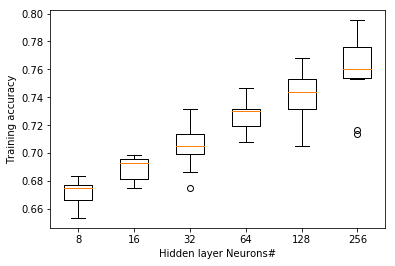

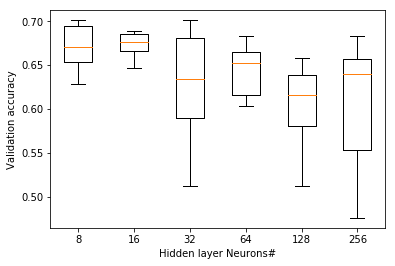

In [51]:
plt.boxplot( accuracy_elu)
plt.xlabel('Hidden layer Neurons#')
plt.ylabel('Training accuracy')
plt.xticks(range(1, len(accuracy_elu)+1), 4* (2**np.arange(1,7)))
plt.show()

plt.boxplot(validation_elu)
plt.xlabel('Hidden layer Neurons#')
plt.ylabel('Validation accuracy')
plt.xticks(range(1,len(accuracy_elu)+1), 4* (2**np.arange(1,7)))
plt.show()

There for increasing the number of "Neurons" in the hidden layer results in overfitting only. So I choose the hidden one hidden layer with 16 "Neurons" and add another layer to the NN with 8 "Neurons":

In [77]:
def NN_2(actived,  X_train, X_test, Y_train, Y_test, Neurons = 100 ):
    model = Sequential([
    Dense(2000, input_shape=(2000,) ),
    Activation('relu')
])
    ### first hidden layer
    model.add(Dense(2*Neurons))
    keras.layers.ELU(alpha=1.0)
    ### second hidden layer

    model.add(Dense(Neurons))
    if actived == 'ELU':
        keras.layers.ELU(alpha=1.0)
        print('ELU acitvation')
    else:
        model.add( Activation (actived))
        

    model.add(Dense( len(np.unique(Y))))
    model.add( Activation('softmax'))
    optimizer = 'Adam' 
    model.compile(optimizer = optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    one_hot_labels_test = keras.utils.to_categorical(Y_test, num_classes = len(np.unique(Y_test)))
    one_hot_labels_train = keras.utils.to_categorical(Y_train, num_classes = len(np.unique(Y_train)))

    history = model.fit(X_train, one_hot_labels_train, validation_data = (X_test,one_hot_labels_test), 
                            epochs = 50, batch_size = 20)
    return history


validation_elu_2    = []
accuracy_elu_2      = []
for i in range(10):
        ### elu
        X_train, X_test, Y_train, Y_test = train_test_split(np.transpose(X), Y, test_size=0.33, random_state=seed)
        history_elu_2 = NN_2( 'ELU',  X_train, X_test, Y_train, Y_test, Neurons = 4* (2) )
        validation_elu_2.append(history_elu_2.history['val_acc'] [-1] )
        accuracy_elu_2.append(history_elu_2.history['acc'] [-1])
        print(validation_elu_2[-1])
        print(accuracy_elu_2[-1])


ELU acitvation
Train on 332 samples, validate on 164 samples
Epoch 1/50
332/332 [==============================] - 5s 15ms/step - loss: 1.4736 - acc: 0.4699 - val_loss: 1.2421 - val_acc: 0.5488
Epoch 2/50
332/332 [==============================] - 1s 3ms/step - loss: 1.3175 - acc: 0.4729 - val_loss: 1.2138 - val_acc: 0.5488
Epoch 3/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2883 - acc: 0.4729 - val_loss: 1.1915 - val_acc: 0.5488
Epoch 4/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2690 - acc: 0.4729 - val_loss: 1.1693 - val_acc: 0.5488
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2624 - acc: 0.4729 - val_loss: 1.1698 - val_acc: 0.5488
Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2444 - acc: 0.4729 - val_loss: 1.1393 - val_acc: 0.5488
Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2579 - acc: 0.4729 - val_loss: 1.1629 - val_acc: 0.5488
Epoch 8/50
332

332/332 [==============================] - 1s 3ms/step - loss: 1.2243 - acc: 0.4789 - val_loss: 1.1257 - val_acc: 0.5488
Epoch 12/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2116 - acc: 0.4729 - val_loss: 1.1236 - val_acc: 0.5549
Epoch 13/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2087 - acc: 0.5301 - val_loss: 1.1163 - val_acc: 0.6220
Epoch 14/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1897 - acc: 0.5211 - val_loss: 1.0932 - val_acc: 0.5854
Epoch 15/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1679 - acc: 0.5542 - val_loss: 1.0742 - val_acc: 0.5793
Epoch 16/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1633 - acc: 0.5452 - val_loss: 1.0600 - val_acc: 0.6098
Epoch 17/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1338 - acc: 0.5904 - val_loss: 1.0493 - val_acc: 0.6585
Epoch 18/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1185

332/332 [==============================] - 1s 3ms/step - loss: 1.0740 - acc: 0.6145 - val_loss: 1.0386 - val_acc: 0.6646
Epoch 23/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0554 - acc: 0.6235 - val_loss: 1.1765 - val_acc: 0.5488
Epoch 24/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0594 - acc: 0.6054 - val_loss: 1.0462 - val_acc: 0.6341
Epoch 25/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0287 - acc: 0.6355 - val_loss: 1.0634 - val_acc: 0.6159
Epoch 26/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0073 - acc: 0.6476 - val_loss: 0.9933 - val_acc: 0.6585
Epoch 27/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0004 - acc: 0.6386 - val_loss: 1.0380 - val_acc: 0.6341
Epoch 28/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0490 - acc: 0.6265 - val_loss: 1.0115 - val_acc: 0.6463
Epoch 29/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9789

332/332 [==============================] - 1s 3ms/step - loss: 0.9388 - acc: 0.6446 - val_loss: 0.9770 - val_acc: 0.6463
Epoch 34/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9269 - acc: 0.6566 - val_loss: 0.9827 - val_acc: 0.6463
Epoch 35/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9181 - acc: 0.6657 - val_loss: 1.0397 - val_acc: 0.6402
Epoch 36/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9654 - acc: 0.6416 - val_loss: 0.9434 - val_acc: 0.6890
Epoch 37/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9331 - acc: 0.6386 - val_loss: 0.9462 - val_acc: 0.6829
Epoch 38/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8999 - acc: 0.6687 - val_loss: 0.9895 - val_acc: 0.6524
Epoch 39/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8868 - acc: 0.6687 - val_loss: 1.0103 - val_acc: 0.6463
Epoch 40/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8873

332/332 [==============================] - 1s 3ms/step - loss: 0.8492 - acc: 0.6928 - val_loss: 0.9679 - val_acc: 0.6646
Epoch 45/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8379 - acc: 0.6958 - val_loss: 1.0101 - val_acc: 0.6524
Epoch 46/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8277 - acc: 0.6988 - val_loss: 0.9847 - val_acc: 0.6768
Epoch 47/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8589 - acc: 0.6717 - val_loss: 0.9964 - val_acc: 0.6707
Epoch 48/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8301 - acc: 0.6988 - val_loss: 0.9788 - val_acc: 0.6829
Epoch 49/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8095 - acc: 0.6988 - val_loss: 1.0584 - val_acc: 0.6037
Epoch 50/50
332/332 [==============================] - 1s 3ms/step - loss: 0.7914 - acc: 0.6928 - val_loss: 0.9924 - val_acc: 0.6707
0.670731710225
0.692771083619
ELU acitvation
Train on 332 samples, validate on 16

332/332 [==============================] - 1s 3ms/step - loss: 1.2616 - acc: 0.4729 - val_loss: 1.1588 - val_acc: 0.5488
Epoch 5/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2526 - acc: 0.4729 - val_loss: 1.1493 - val_acc: 0.5488
Epoch 6/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2480 - acc: 0.4729 - val_loss: 1.1482 - val_acc: 0.5488
Epoch 7/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2454 - acc: 0.4729 - val_loss: 1.1528 - val_acc: 0.5488
Epoch 8/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2443 - acc: 0.4729 - val_loss: 1.1355 - val_acc: 0.5488
Epoch 9/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2438 - acc: 0.4729 - val_loss: 1.1475 - val_acc: 0.5488
Epoch 10/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2515 - acc: 0.4729 - val_loss: 1.1571 - val_acc: 0.5488
Epoch 11/50
332/332 [==============================] - 1s 3ms/step - loss: 1.2265 - ac

332/332 [==============================] - 1s 3ms/step - loss: 1.1357 - acc: 0.5753 - val_loss: 1.0594 - val_acc: 0.6646
Epoch 16/50
332/332 [==============================] - 1s 3ms/step - loss: 1.1159 - acc: 0.5964 - val_loss: 1.0232 - val_acc: 0.5915
Epoch 17/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0983 - acc: 0.6054 - val_loss: 1.0168 - val_acc: 0.6768
Epoch 18/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0668 - acc: 0.6114 - val_loss: 1.0141 - val_acc: 0.5976
Epoch 19/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0722 - acc: 0.6054 - val_loss: 0.9875 - val_acc: 0.6280
Epoch 20/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0776 - acc: 0.5843 - val_loss: 1.0005 - val_acc: 0.6280
Epoch 21/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0292 - acc: 0.6175 - val_loss: 0.9607 - val_acc: 0.6890
Epoch 22/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0246

332/332 [==============================] - 1s 3ms/step - loss: 0.9788 - acc: 0.6355 - val_loss: 0.9617 - val_acc: 0.6768
Epoch 27/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9794 - acc: 0.6295 - val_loss: 0.9591 - val_acc: 0.6707
Epoch 28/50
332/332 [==============================] - 1s 3ms/step - loss: 1.0037 - acc: 0.6084 - val_loss: 0.9959 - val_acc: 0.6220
Epoch 29/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9820 - acc: 0.6054 - val_loss: 0.9592 - val_acc: 0.6768
Epoch 30/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9304 - acc: 0.6566 - val_loss: 0.9466 - val_acc: 0.6707
Epoch 31/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9241 - acc: 0.6506 - val_loss: 0.9487 - val_acc: 0.6829
Epoch 32/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9133 - acc: 0.6446 - val_loss: 0.9448 - val_acc: 0.6768
Epoch 33/50
332/332 [==============================] - 1s 3ms/step - loss: 0.9026

332/332 [==============================] - 1s 3ms/step - loss: 0.8807 - acc: 0.6717 - val_loss: 0.9162 - val_acc: 0.6951
Epoch 38/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8768 - acc: 0.6747 - val_loss: 0.9168 - val_acc: 0.6890
Epoch 39/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8964 - acc: 0.6657 - val_loss: 1.0005 - val_acc: 0.6220
Epoch 40/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8621 - acc: 0.6777 - val_loss: 0.9480 - val_acc: 0.6707
Epoch 41/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8424 - acc: 0.6958 - val_loss: 0.9339 - val_acc: 0.6890
Epoch 42/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8475 - acc: 0.6867 - val_loss: 1.0288 - val_acc: 0.6037
Epoch 43/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8495 - acc: 0.6837 - val_loss: 0.9195 - val_acc: 0.7012
Epoch 44/50
332/332 [==============================] - 1s 3ms/step - loss: 0.8689

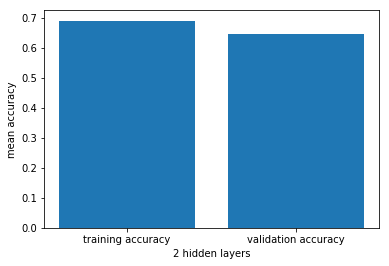

In [80]:
plt.bar(range(1,3),[np.mean(accuracy_elu_2 ),np.mean(validation_elu_2)] )

plt.xlabel('2 hidden layers')
plt.ylabel('mean accuracy')
plt.xticks(range(1,3), ['training accuracy','validation accuracy'])
plt.show()

Adding layes won't help with the predictions, so we go back to one hidden layer model.

Why did you choose the neural network architecture, loss function and data processing steps in your code?
----
I chose categorical_crossentropy and softmax since they are compatible with categorical predications.

The optimizer choice is not a crucial choice, rmsprop optimizer approaches the minimum fast in the beginning of iterations but Adam wins against rmsprop at the longer runs and approaches the minimum more accurately at the end, ref. https://arxiv.org/pdf/1412.6980.pdf



I have chosen different types of architectures and explored their impact on the accuracy of the model. Here I have shown hidden layer with 100 neurons and ELU works very good to predict the labels.



What strategy did you employ to assess model generalization and why?
-----
I used a validation set for this model consisting of 33% of the data set and applied the method and validated the accuracy of the model on this dataset. I have repeated this by random selection of validation and training sets to find a more accurate answer. To generalize further we can performe k-fold cross validation and also make a test set to further assess the model on.



A clinical researcher wants to take your model into a clinical trial; however, they are only able to measure 100 genes instead of performing a genome-wide analysis. How would you choose the 100 genes for your model?
-----
 In the model in hand, I do a feature selection to come upo with the best predictive set pf genes in the following way: 
 
I cluster the 2000 genes with highest variance based on correlation distance and perform clustering preferably with Ward.D2, cut the clustering tree so I end up with 100 clusters and choose a representative gene from each cluster. I choose the gene with the largest variance personally since inferring the signal from largest values of variance is easier. I train the model with the selected genes.
 
 
 
If you had additional time what additional forms of analysis would you perform to improve your neural network model?
----
I have added PCA here already for this purpose.
I Would add regularization and dropouts for overfitting issues especially when we add more layers to the NN
